# Bayes models
#### Transformation model based variational inference (TM-VI)
#### Image data: CIb model , compare MF-Gaussian-VI with MF-TM-VI (last layer FCNN)

In [68]:
# packages

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import seaborn as sns
from numpy.random import seed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from tensorflow.keras import layers
from functions.scoreCI import score_ci
from tensorflow.keras import regularizers
%load_ext autoreload
%autoreload 2
import glob
from functions.vimlts import VimltsLinear,DenseViGauss 
from functions.sample_bernoulli_nll import sample_bernoulli_nll

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  1


In [3]:
## add resize images and add path to patient
dat = pd.read_csv('../MA/patientData.csv')
train_dir = "../MA/trainRes/"
dat['path'] = train_dir + dat.image_name + ".jpg"


In [4]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)


train_idx = idx[:int(len(dat)*0.8)] # 80% training
test_idx = idx[int(len(dat)*0.8):] # 20% test
valid_idx = train_idx[:int(len(train_idx)*0.2)] # 20% of training as validation
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [8]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
print(X_train.shape, X_valid.shape, X_test.shape)

(21200, 9) (5300, 9) (6626, 9)


In [5]:
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)


In [9]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# img_to_array image als array transformieren
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)
train_labels = y_train

validation_imgs = np.array(validation_imgs)
val_labels = y_valid
#
test_imgs = np.array(test_imgs)
test_labels = y_test


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,
     '\Test dataset shape:', test_imgs.shape)

Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


In [10]:
#scale pixel zwischen 0 und 1

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

#plt.imshow(train_imgs_scaled[0])


In [11]:
def softplus_inv(y):
    return np.log(np.exp(y) - 1)

# Log-Score   
def logScore(y_obs, y_pred):
    likelihoodElements= (y_obs*np.log(y_pred) + (1 - y_obs)*np.log(1 - y_pred))
    logScore = np.mean(likelihoodElements)
    return logScore.values[0]


#combine two components
def modelOn(X):
    added = X.layers[14].output   ## before sigmoid to obtain eta(B)
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = X.input, outputs = out, name='model_XXX')
    return model1 
    
prior_dist=tfd.Normal(loc=0.,scale=1.)

## Gauß-VI last-layer eta Bild

In [12]:
## Complex shift image
from tensorflow.keras import regularizers

    
in_ = keras.Input(shape = (128,128,3), name = "inImg")
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01), ##numerical stability
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
out= DenseViGauss(units=1,
                      activation=tf.keras.activations.linear,
                      num_samples=1000,     
                      prior_dist=prior_dist)(x)

nn_imG = keras.Model (inputs = in_, outputs = out)
nn_imG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inImg (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0     

In [13]:

nn_image = modelOn(nn_imG)
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5

#### Train model

In [11]:
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5
results = nn_image.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 100,
                        verbose= True)    

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-11-19 11:05:59.214826: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4168089600 exceeds 10% of free system memory.
2021-11-19 11:06:00.532999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 11:06:00.552145: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2021-11-19 11:06:01.187271: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-19 11:06:01.404876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-19 11:06:02.504244: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-19 11:06:02.692655: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx 

83/83 [==============================] - 84s 623ms/step - loss: 4.2954 - val_loss: 3.6979
Epoch 2/100
83/83 [==============================] - 6s 74ms/step - loss: 3.5204 - val_loss: 3.0225
Epoch 3/100
83/83 [==============================] - 6s 74ms/step - loss: 2.8768 - val_loss: 2.4727
Epoch 4/100
83/83 [==============================] - 6s 75ms/step - loss: 2.3582 - val_loss: 2.0430
Epoch 5/100
83/83 [==============================] - 6s 75ms/step - loss: 1.9542 - val_loss: 1.7104
Epoch 6/100
83/83 [==============================] - 6s 74ms/step - loss: 1.6380 - val_loss: 1.4433
Epoch 7/100
83/83 [==============================] - 6s 75ms/step - loss: 1.3851 - val_loss: 1.2230
Epoch 8/100
83/83 [==============================] - 6s 74ms/step - loss: 1.1772 - val_loss: 1.0378
Epoch 9/100
83/83 [==============================] - 6s 75ms/step - loss: 1.0007 - val_loss: 0.8846
Epoch 10/100
83/83 [==============================] - 6s 75ms/step - loss: 0.8523 - val_loss: 0.7590
Epoch 11/

83/83 [==============================] - 6s 76ms/step - loss: 0.0960 - val_loss: 0.1005
Epoch 83/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0958 - val_loss: 0.0987
Epoch 84/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0939 - val_loss: 0.0983
Epoch 85/100
83/83 [==============================] - 6s 76ms/step - loss: 0.0953 - val_loss: 0.0980
Epoch 86/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0932 - val_loss: 0.0991
Epoch 87/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0873 - val_loss: 0.1002
Epoch 88/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0927 - val_loss: 0.0973
Epoch 89/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0869 - val_loss: 0.0990
Epoch 90/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0899 - val_loss: 0.0977
Epoch 91/100
83/83 [==============================] - 6s 75ms/step - loss: 0.0916 - val_loss: 0.0985
Epo

In [15]:
# save results
#dat = pd.DataFrame({'train_loss': results.history['loss'], 
 #                      'test_loss': results.history['val_loss']})
#dat.to_csv('../thesis/performance/gaussVI/history.csv', index=False)

### save model weights whole model
#nn_image.save_weights("../thesis/models/CNNGaus", save_format ="tf")
### save model weights eta
#nn_imG.save_weights("../thesis/models/CNNGaussEta", save_format ="tf")


#### Load model weights

In [14]:
### recreate Model eta
nn_imG.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_imG.load_weights("../thesis/models/CNNGaussEta")

### recreate whole Model
nn_image.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_image.load_weights("../thesis/models/CNNGaus")

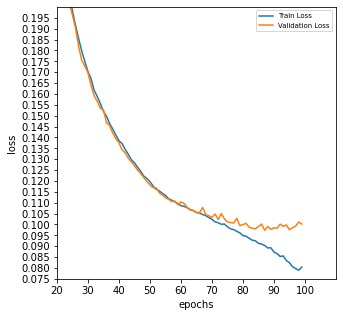

In [15]:

plt.figure(figsize=(5,5))
loss0 = pd.read_csv('../thesis/performance/gaussVI/history.csv')
plt.plot(loss0['train_loss'],label="Train Loss")
plt.plot(loss0['test_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.075,0.2)
plt.yticks(np.arange(0.075, 0.2, 0.005))
plt.xticks(np.arange(20, 110, 10))
plt.xlim(20,110)
plt.legend(fontsize='x-small')

## Performance

In [17]:
y_pred = nn_image.predict(test_imgs_scaled,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

2021-11-19 11:24:24.579919: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.


In [18]:
logScore(test_labels,predictions)

-0.07697289497874951

In [19]:
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)

AUC=0.82, 95% CI: 0.79-0.86


### PPD Evaluation on OOD data only on eta(B) 

In [70]:
## random images 
filelist = glob.glob('../thesis/oodImages/*.npy')
x = [np.array(np.load(fname)) for fname in filelist]
randomX = np.asarray(x)
oodRandom = randomX.reshape(17,128,128,3)
oodRandom.shape

(17, 128, 128, 3)

In [73]:
## augmentation images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(factor=0.9, fill_mode="wrap"),
  layers.experimental.preprocessing.RandomTranslation(height_factor=1, width_factor=1, fill_mode="reflect"),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])
# Add the image to a batch
image= test_imgs_scaled[300:403] 
augmented_image = data_augmentation(image)
bright = tf.image.adjust_brightness(augmented_image, 0.2) ##add additionaly brightness 
bright.shape
#plt.imshow(bright[10])
#plt.axis("off")

TensorShape([103, 128, 128, 3])

### prediction on OOD
1. eta(B)

In [63]:

##eta with random images
Gy_predTabOOD = nn_imG.predict(oodRandom,batch_size =1)
GsamplesImgOOD = Gy_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOOD = GsamplesImgOOD.mean(axis=1)  ###mean samples 
GpredictionsImgOOD=GmeanpredImgOOD.reshape(17,1)
## IQR Range
Gy_predictions_25ImgOOD=np.quantile(GsamplesImgOOD,0.25,axis=1)  
Gy_predictions_75IMGOOD=np.quantile(GsamplesImgOOD,0.75,axis=1)

##dataframe
GImgCenterOOD = [sublist[-1] for sublist in GpredictionsImgOOD]
GImgLowOOD = [sublist[-1] for sublist in Gy_predictions_25ImgOOD.reshape(17,1)]
GImgHighOOD = [sublist[-1] for sublist in Gy_predictions_75IMGOOD.reshape(17,1)]
GImgwidthOOD= [x1 - x2 for (x1, x2) in zip(GImgHighOOD, GImgLowOOD)]

##eta augmented images
Gy_predTabOODA = nn_imG.predict(bright,batch_size =1)
GsamplesImgOODA = Gy_predTabOODA.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOODA = GsamplesImgOODA.mean(axis=1)  ###mean samples 
GpredictionsImgOODA=GmeanpredImgOODA.reshape(103,1)
Gy_predictions_25ImgOODA=np.quantile(GsamplesImgOODA,0.25,axis=1)
Gy_predictions_75IMGOODA=np.quantile(GsamplesImgOODA,0.75,axis=1)

##dataframe
GImgCenterOODA = [sublist[-1] for sublist in GpredictionsImgOODA]
GImgLowOODA = [sublist[-1] for sublist in Gy_predictions_25ImgOODA.reshape(103,1)]
GImgHighOODA = [sublist[-1] for sublist in Gy_predictions_75IMGOODA.reshape(103,1)]
GImgwidthOODA= [x1 - x2 for (x1, x2) in zip(GImgHighOODA, GImgLowOODA)]

In [64]:
##PPD

Gy_predTabOODWhole = nn_image.predict(f,batch_size =1)



GsamplesImgOODWhole = Gy_predTabOODWhole.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOODWhole = GsamplesImgOODWhole.mean(axis=1)  ###mean samples 
GpredictionsImgOODWhole=GmeanpredImgOODWhole.reshape(17,1)

Gy_predictions_25ImgOODWhole=np.quantile(GsamplesImgOODWhole,0.25,axis=1)
Gy_predictions_75IMGOODWhole=np.quantile(GsamplesImgOODWhole,0.75,axis=1)


##dataframe
GImgCenterOODWhole = [sublist[-1] for sublist in GpredictionsImgOODWhole]
GImgLowOODWhole = [sublist[-1] for sublist in Gy_predictions_25ImgOODWhole.reshape(17,1)]
GImgHighOODWhole = [sublist[-1] for sublist in Gy_predictions_75IMGOODWhole.reshape(17,1)]
GImgwidthOODWhole= [x1 - x2 for (x1, x2) in zip(GImgHighOODWhole, GImgLowOODWhole)]

##PPD augment

Gy_predTabOODWholeA = nn_image.predict(bright,batch_size =1)



GsamplesImgOODWholeA = Gy_predTabOODWholeA.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOODWholeA = GsamplesImgOODWholeA.mean(axis=1)  ###mean samples 
GpredictionsImgOODWholeA=GmeanpredImgOODWholeA.reshape(103,1)

Gy_predictions_25ImgOODWholeA=np.quantile(GsamplesImgOODWholeA,0.25,axis=1)
Gy_predictions_75IMGOODWholeA=np.quantile(GsamplesImgOODWholeA,0.75,axis=1)


##dataframe
GImgCenterOODWholeA = [sublist[-1] for sublist in GpredictionsImgOODWholeA]
GImgLowOODWholeA = [sublist[-1] for sublist in Gy_predictions_25ImgOODWholeA.reshape(103,1)]
GImgHighOODWholeA = [sublist[-1] for sublist in Gy_predictions_75IMGOODWholeA.reshape(103,1)]
GImgwidthOODWholeA= [x1 - x2 for (x1, x2) in zip(GImgHighOODWholeA, GImgLowOODWholeA)]




In [65]:
###vorbereitung image


Gy_pred = nn_imG.predict(test_imgs_scaled[0:120],batch_size =1)


Gsamples = Gy_pred.reshape(-1, 1000) ###every datapoint one sample
Gmeanpred = Gsamples.mean(axis=1)  ###mean samples 
Gpredictions=Gmeanpred.reshape(120,1)

Gy_predictions_25=np.quantile(Gsamples,0.25,axis=1)
Gy_predictions_75=np.quantile(Gsamples,0.75,axis=1)


#
GImgCenter = [sublist[-1] for sublist in Gmeanpred.reshape(120,1)]
GImgLow = [sublist[-1] for sublist in Gy_predictions_25.reshape(120,1)]
GImgHigh = [sublist[-1] for sublist in Gy_predictions_75.reshape(120,1)]
GImgwidth= [x1 - x2 for (x1, x2) in zip(GImgHigh, GImgLow)]






Gimagedata = pd.DataFrame(
    {'Gwidth': GImgwidth,
     'Gcenter': GImgCenter
    })

###Out of distribution

GimagadataOOD = pd.DataFrame(
    {'Gwidth': GImgwidthOOD,
     'Gcenter': GImgCenterOOD
    })

###Out of distribution

GimagadataOODA = pd.DataFrame(
    {'Gwidth': GImgwidthOODA,
     'Gcenter': GImgCenterOODA
    })

In [66]:
###vorbereitung image whole


Gy_predWhole = nn_image.predict(test_imgs_scaled[0:120],batch_size =1)


GsamplesWhole = Gy_predWhole.reshape(-1, 1000) ###every datapoint one sample
GmeanpredWhole = GsamplesWhole.mean(axis=1)  ###mean samples 
GpredictionsWhole=GmeanpredWhole.reshape(120,1)

Gy_predictions_25Whole=np.quantile(GsamplesWhole,0.25,axis=1)
Gy_predictions_75Whole=np.quantile(GsamplesWhole,0.75,axis=1)


#
GImgCenterWhole = [sublist[-1] for sublist in GmeanpredWhole.reshape(120,1)]
GImgLowWhole = [sublist[-1] for sublist in Gy_predictions_25Whole.reshape(120,1)]
GImgHighWhole = [sublist[-1] for sublist in Gy_predictions_75Whole.reshape(120,1)]
GImgwidthWhole= [x1 - x2 for (x1, x2) in zip(GImgHighWhole, GImgLowWhole)]






GimagedataWhole = pd.DataFrame(
    {'Gwidth': GImgwidthWhole,
     'Gcenter': GImgCenterWhole
    })

###Out of distribution

GimagadataOODWhole = pd.DataFrame(
    {'Gwidth': GImgwidthOODWhole,
     'Gcenter': GImgCenterOODWhole
    })

###Out of distribution

GimagadataOODWholeA = pd.DataFrame(
    {'Gwidth': GImgwidthOODWholeA,
     'Gcenter': GImgCenterOODWholeA
    })

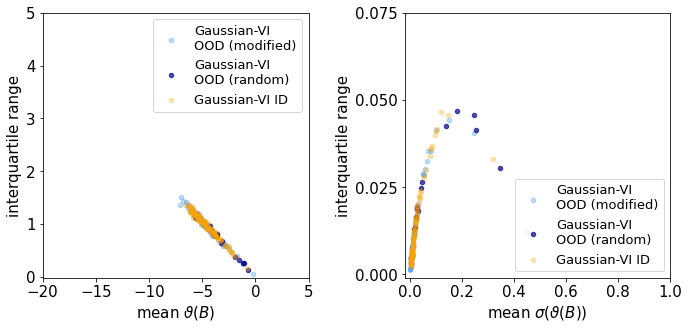

In [67]:

fig = plt.figure(figsize=(10,5))

plt.rcParams.update(({'font.size': 15}))





fig.add_subplot(121)
plt.scatter(GimagadataOODA["Gcenter"],GimagadataOODA["Gwidth"],label="Gaussian-VI\nOOD (modified)",s=20,alpha=0.3, color="dodgerblue")
plt.scatter(GimagadataOOD["Gcenter"],GimagadataOOD["Gwidth"],label="Gaussian-VI\nOOD (random)",s=20,alpha=0.7,color="darkblue")
plt.scatter(Gimagedata["Gcenter"],Gimagedata["Gwidth"],label="Gaussian-VI ID",alpha=0.3,s=20,color="orange")
plt.ylabel("interquartile range")
plt.xlabel("mean $\\vartheta(B)$")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=13)



fig.add_subplot(122)
plt.scatter(GimagadataOODWholeA["Gcenter"],GimagadataOODWholeA["Gwidth"],label="Gaussian-VI\nOOD (modified)",s=20,alpha=0.3, color="dodgerblue")
plt.scatter(GimagadataOODWhole["Gcenter"],GimagadataOODWhole["Gwidth"],label="Gaussian-VI\nOOD (random)",s=20,alpha=0.7, color="darkblue")
plt.scatter(GimagedataWhole["Gcenter"],GimagedataWhole["Gwidth"],label="Gaussian-VI ID",alpha=0.3,s=20,color="orange")
plt.legend(fontsize=13,loc="lower right")
plt.ylabel("interquartile range")
plt.xlabel("mean $\sigma(\\vartheta(B)$)")
plt.yticks(np.arange(0, 0.1, 0.025))
plt.xticks(np.arange(0, 1.2, 0.2))
fig.tight_layout(pad=1.5)
#plt.savefig("./plots/uncertainty/imagegausTMVIcompare2.pdf")




## CNN Last layer TMVI

In [35]:

### Kein Bias Bei Linear Shift
M=50

prior_dist=tfd.Normal(0.,1.)    ##normal
theta_start = -3  ##Range von Gauss-VI
theta_stop = 3



vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] +
                              [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])                 

In [36]:
from tensorflow.keras import regularizers

in_ = keras.Input(shape = (128,128,3), name = "inImg")
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
eta = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,    ###Linear
                      num_samples=1000,
                      size = 21200,
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x)
nn_im = keras.Model (inputs = in_, outputs = eta)
nn_im.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inImg (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_____________________________________________________

In [37]:

##add 
def modelOn(X):
    added = X.layers[14].output
    #out = tf.keras.layers.Dense(1, activation = 'sigmoid',use_bias=False, trainable=False)(added)
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = X.input, outputs = out, name='model_XXX')
    return model1 
nn_image = modelOn(nn_im)

In [231]:

nn_image = modelOn(nn_im)
nn_image.compile(optimizer=Adam(1e-5), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5
results = nn_image.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 250, ##250
                        verbose= True)  

Epoch 1/250
83/83 [==============================] - 12s 126ms/step - loss: 7.3253 - val_loss: 6.9297
Epoch 2/250
83/83 [==============================] - 10s 117ms/step - loss: 6.9064 - val_loss: 6.8445
Epoch 3/250
83/83 [==============================] - 10s 117ms/step - loss: 6.8240 - val_loss: 6.7642
Epoch 4/250
83/83 [==============================] - 10s 117ms/step - loss: 6.7437 - val_loss: 6.6835
Epoch 5/250
83/83 [==============================] - 10s 117ms/step - loss: 6.6628 - val_loss: 6.6018
Epoch 6/250
83/83 [==============================] - 10s 117ms/step - loss: 6.5812 - val_loss: 6.5199
Epoch 7/250
83/83 [==============================] - 10s 117ms/step - loss: 6.4993 - val_loss: 6.4378
Epoch 8/250
83/83 [==============================] - 10s 117ms/step - loss: 6.4170 - val_loss: 6.3548
Epoch 9/250
83/83 [==============================] - 10s 117ms/step - loss: 6.3334 - val_loss: 6.2718
Epoch 10/250
83/83 [==============================] - 10s 117ms/step - loss: 6.250

83/83 [==============================] - 10s 117ms/step - loss: 2.0828 - val_loss: 2.0740
Epoch 160/250
83/83 [==============================] - 10s 117ms/step - loss: 2.0636 - val_loss: 2.0697
Epoch 161/250
83/83 [==============================] - 10s 117ms/step - loss: 2.0665 - val_loss: 2.0638
Epoch 162/250
83/83 [==============================] - 10s 117ms/step - loss: 2.0612 - val_loss: 2.0587
Epoch 163/250
83/83 [==============================] - 10s 118ms/step - loss: 2.0562 - val_loss: 2.0547
Epoch 164/250
83/83 [==============================] - 10s 117ms/step - loss: 2.0568 - val_loss: 2.0490
Epoch 165/250
83/83 [==============================] - 10s 118ms/step - loss: 2.0454 - val_loss: 2.0446
Epoch 166/250
83/83 [==============================] - 10s 117ms/step - loss: 2.0387 - val_loss: 2.0393
Epoch 167/250
83/83 [==============================] - 10s 118ms/step - loss: 2.0334 - val_loss: 2.0344
Epoch 168/250
83/83 [==============================] - 10s 117ms/step - loss: 

KeyboardInterrupt: 

In [ ]:
# save results
dat = pd.DataFrame({'train_loss': results.history['loss'], 
                        'test_loss': results.history['val_loss']})
dat.to_csv('./performance/imageTMVI/history.csv', index=False)

In [35]:
loss1 = pd.read_csv('./performance/imageTMVI/history.csv')

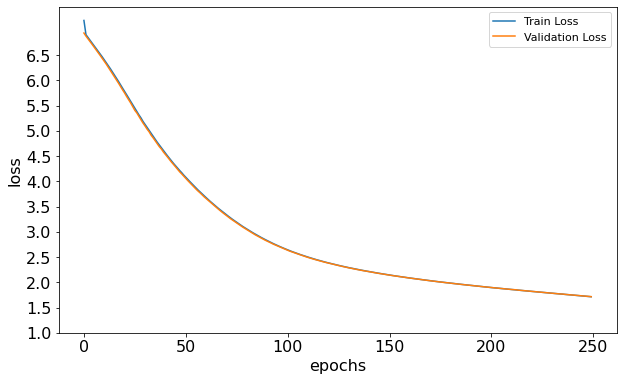

In [70]:
plt.figure(figsize=(10,6))
plt.rcParams.update(({'font.size': 16}))
plt.plot(loss1['train_loss'],label="Train Loss")
plt.plot(loss1['test_loss'], label="Validation Loss")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
#plt.ylim(1,4)
plt.yticks(np.arange(1, 7, 0.5))
plt.legend(fontsize='x-small')
#plt.yscale('log')

In [19]:
#### save model weights only eta
#nn_im.save_weights("models/CNNLastLayerTMVI", save_format ="tf")
#### save model weights whole model
#nn_image.save_weights("models/CNNLastLayerTMVIWhole", save_format ="tf")

In [38]:
### recreate Model eta
nn_im.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_im.load_weights("models/CNNLastLayerTMVI")

### recreate whole Model
nn_image.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
#nn_im.fit(x =train_imgs_scaled,y = train_labels, verbose=True)
### load the state of the old model
nn_image.load_weights("models/CNNLastLayerTMVIWhole")

## Posterior for 1, 2 images

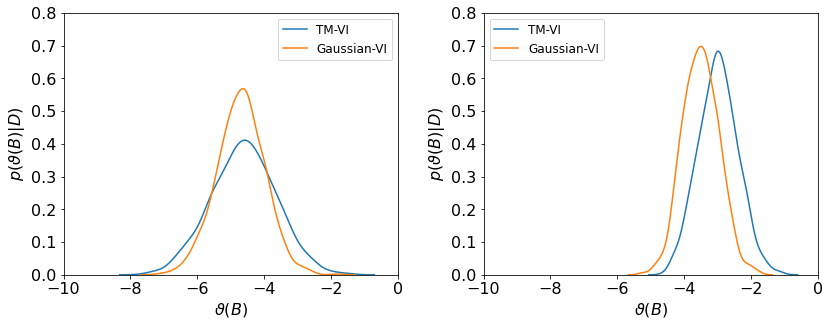

In [204]:



fig =plt.figure(figsize=(12,5))
plt.rcParams.update(({'font.size': 16}))
plt.subplot(121)
y_pred = nn_im.predict(test_imgs_scaled[8:9],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2,label="TM-VI")

y_pred = nn_imG.predict(test_imgs_scaled[8:9],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2, label="Gaussian-VI")
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(np.arange(-10, 2, 2))
plt.xlabel("$\\vartheta(B)$")
plt.ylabel("$p(\\vartheta(B)|D)$")



plt.legend(fontsize=12)









plt.subplot(122)
y_pred = nn_im.predict(test_imgs_scaled[7:8],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2,label="TM-VI")

y_pred = nn_imG.predict(test_imgs_scaled[7:8],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2, label="Gaussian-VI")
plt.xlabel("$\\vartheta(B)$")
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(np.arange(-10, 2, 2))
plt.ylabel("$p(\\vartheta(B)|D)$")
plt.legend(fontsize=12)



 











fig.tight_layout(pad=1.5)

plt.savefig('./plots/uncertainty/imagePosteriorExamples.pdf')


plt.show()




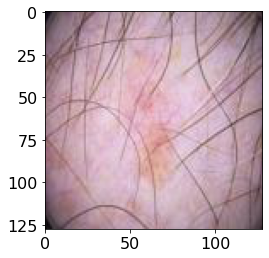

In [205]:
plt.imshow(train_imgs_scaled[7:8][0])

In [48]:
y_pred = nn_image.predict(test_imgs_scaled,batch_size =1)
samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

2021-11-16 22:11:21.307301: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1302724608 exceeds 10% of free system memory.


In [111]:
ss = np.argmax(predictions,axis=1)
u =test_labels.values

In [112]:
indices = [i for i,v in enumerate(ss) if ss[i]!=u[i]]

In [113]:
indicesCorrect = [i for i,v in enumerate(ss) if ss[i]==u[i]]

In [110]:
testMiss = test_imgs_scaled[indices]
testCorrect= test_imgs_scaled[indicesCorrect]


116

In [170]:
logloss = neg_log_likelihood(test_labels,predictions)
logloss

0.0764193419706728

In [259]:
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)

AUC=0.83, 95% CI: 0.80-0.86


## OOD 

In [39]:
###eta
y_predTabOOD = nn_im.predict(random,batch_size =1)



samplesImgOOD = y_predTabOOD.reshape(-1, 1000) ###every datapoint one sample

meanpredImgOOD = samplesImgOOD.mean(axis=1)  ###mean samples 
predictionsImgOOD=meanpredImgOOD.reshape(17,1)

y_predictions_25ImgOOD=np.quantile(samplesImgOOD,0.25,axis=1)
y_predictions_75IMGOOD=np.quantile(samplesImgOOD,0.75,axis=1)


##dataframe
ImgCenterOOD = [sublist[-1] for sublist in predictionsImgOOD]
ImgLowOOD = [sublist[-1] for sublist in y_predictions_25ImgOOD.reshape(17,1)]
ImgHighOOD = [sublist[-1] for sublist in y_predictions_75IMGOOD.reshape(17,1)]
ImgwidthOOD= [x1 - x2 for (x1, x2) in zip(ImgHighOOD, ImgLowOOD)]


###eta
y_predTabOODA = nn_im.predict(bright,batch_size =1)



samplesImgOODA = y_predTabOODA.reshape(-1, 1000) ###every datapoint one sample

meanpredImgOODA = samplesImgOODA.mean(axis=1)  ###mean samples 
predictionsImgOODA=meanpredImgOODA.reshape(103,1)

y_predictions_25ImgOODA=np.quantile(samplesImgOODA,0.25,axis=1)
y_predictions_75IMGOODA=np.quantile(samplesImgOODA,0.75,axis=1)


##dataframe
ImgCenterOODA = [sublist[-1] for sublist in predictionsImgOODA]
ImgLowOODA = [sublist[-1] for sublist in y_predictions_25ImgOODA.reshape(103,1)]
ImgHighOODA = [sublist[-1] for sublist in y_predictions_75IMGOODA.reshape(103,1)]
ImgwidthOODA= [x1 - x2 for (x1, x2) in zip(ImgHighOODA, ImgLowOODA)]

In [40]:
##PPD

y_predTabOODWhole = nn_image.predict(random,batch_size =1)



samplesImgOODWhole = y_predTabOODWhole.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOODWhole = samplesImgOODWhole.mean(axis=1)  ###mean samples 

predictionsImgOODWhole=meanpredImgOODWhole.reshape(17,1)

y_predictions_25ImgOODWhole=np.quantile(samplesImgOODWhole,0.25,axis=1)
y_predictions_75IMGOODWhole=np.quantile(samplesImgOODWhole,0.75,axis=1)


##dataframe
ImgCenterOODWhole = [sublist[-1] for sublist in predictionsImgOODWhole]
ImgLowOODWhole = [sublist[-1] for sublist in y_predictions_25ImgOODWhole.reshape(17,1)]
ImgHighOODWhole = [sublist[-1] for sublist in y_predictions_75IMGOODWhole.reshape(17,1)]
ImgwidthOODWhole= [x1 - x2 for (x1, x2) in zip(ImgHighOODWhole, ImgLowOODWhole)]


##PPD

y_predTabOODWholeA = nn_image.predict(bright,batch_size =1)



samplesImgOODWholeA = y_predTabOODWholeA.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOODWholeA = samplesImgOODWholeA.mean(axis=1)  ###mean samples 

predictionsImgOODWholeA=meanpredImgOODWholeA.reshape(103,1)

y_predictions_25ImgOODWholeA=np.quantile(samplesImgOODWholeA,0.25,axis=1)
y_predictions_75IMGOODWholeA=np.quantile(samplesImgOODWholeA,0.75,axis=1)


##dataframe
ImgCenterOODWholeA = [sublist[-1] for sublist in predictionsImgOODWholeA]
ImgLowOODWholeA = [sublist[-1] for sublist in y_predictions_25ImgOODWholeA.reshape(103,1)]
ImgHighOODWholeA = [sublist[-1] for sublist in y_predictions_75IMGOODWholeA.reshape(103,1)]
ImgwidthOODWholeA= [x1 - x2 for (x1, x2) in zip(ImgHighOODWholeA, ImgLowOODWholeA)]

In [41]:
###vorbereitung image


y_pred = nn_im.predict(test_imgs_scaled[0:120],batch_size =1)


samples = y_pred.reshape(-1, 1000) ###every datapoint one sample

meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(120,1)

y_predictions_25=np.quantile(samples,0.25,axis=1)
y_predictions_75=np.quantile(samples,0.75,axis=1)


#
ImgCenter = [sublist[-1] for sublist in meanpred.reshape(120,1)]
ImgLow = [sublist[-1] for sublist in y_predictions_25.reshape(120,1)]
ImgHigh = [sublist[-1] for sublist in y_predictions_75.reshape(120,1)]
Imgwidth= [x1 - x2 for (x1, x2) in zip(ImgHigh, ImgLow)]






imagedata = pd.DataFrame(
    {'width': Imgwidth,
     'center': ImgCenter
    })

###Out of distribution

imagadataOOD = pd.DataFrame(
    {'width': ImgwidthOOD,
     'center': ImgCenterOOD
    })

###Out of distribution

imagadataOODA = pd.DataFrame(
    {'width': ImgwidthOODA,
     'center': ImgCenterOODA
    })

In [42]:
###vorbereitung image whole


y_predWhole = nn_image.predict(test_imgs_scaled[0:120],batch_size =1)


samplesWhole = y_predWhole.reshape(-1, 1000) ###every datapoint 1000 samples
meanpredWhole = samplesWhole.mean(axis=1)  ###mean samples 
entropy_Correcet = -np.sum(y_predWhole * np.log2(y_predWhole ),axis=1) 
predictionsWhole=meanpredWhole.reshape(120,1)

y_predictions_25Whole=np.quantile(samplesWhole,0.25,axis=1)
y_predictions_75Whole=np.quantile(samplesWhole,0.75,axis=1)


#
ImgCenterWhole = [sublist[-1] for sublist in meanpredWhole.reshape(120,1)]
ImgLowWhole = [sublist[-1] for sublist in y_predictions_25Whole.reshape(120,1)]
ImgHighWhole = [sublist[-1] for sublist in y_predictions_75Whole.reshape(120,1)]
ImgwidthWhole= [x1 - x2 for (x1, x2) in zip(ImgHighWhole, ImgLowWhole)]






imagedataWhole = pd.DataFrame(
    {'width': ImgwidthWhole,
     'center': ImgCenterWhole
    })

###Out of distribution

imagadataOODWhole = pd.DataFrame(
    {'width': ImgwidthOODWhole,
     'center': ImgCenterOODWhole
    })

###Out of distribution

imagadataOODWholeA = pd.DataFrame(
    {'width': ImgwidthOODWholeA,
     'center': ImgCenterOODWholeA
    })

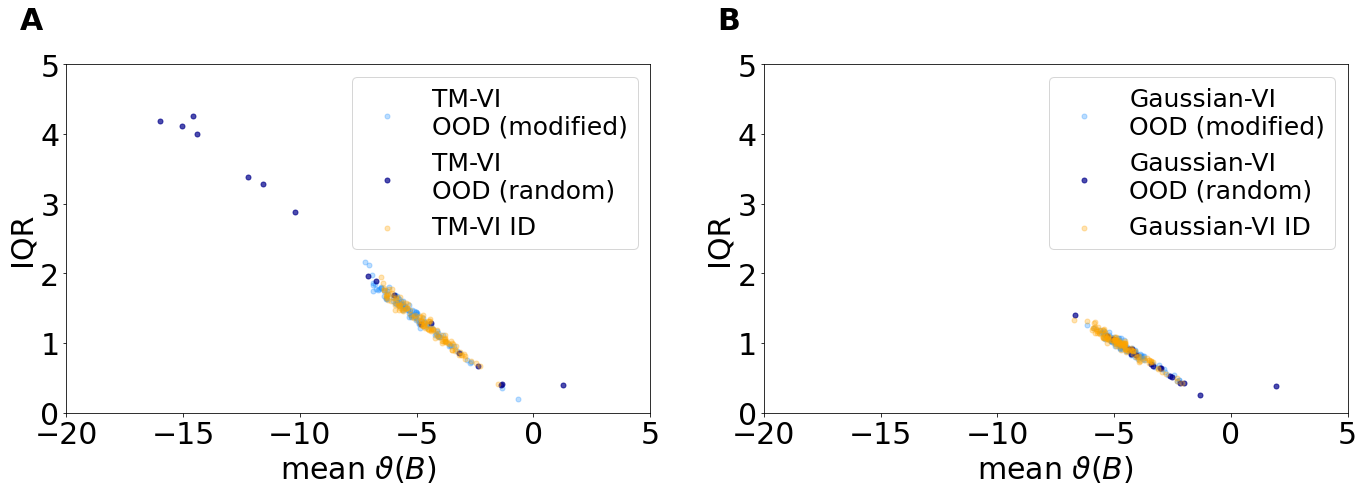

In [43]:
fig = plt.figure(figsize=(20,8))

plt.rcParams.update(({'font.size': 30}))



fig.add_subplot(121)
plt.scatter(imagadataOODA["center"],imagadataOODA["width"],alpha=0.3,s=25, label= "TM-VI\nOOD (modified)",color="dodgerblue")
plt.scatter(imagadataOOD["center"],imagadataOOD["width"],alpha=0.7,s=25, label= "TM-VI\nOOD (random)",color="darkblue")
plt.scatter(imagedata["center"],imagedata["width"],label="TM-VI ID",alpha=0.3,s=25,color="orange")
plt.text(-22, 5.5,"A", 
            size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean $\\vartheta(B)$")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=25)



#fig.add_subplot(122)
#plt.scatter(imagadataOODWholeA["center"],imagadataOODWholeA["width"],label="TM-VI\nOOD (modified)",alpha=0.3,s=20,color="dodgerblue")
#plt.scatter(imagadataOODWhole["center"],imagadataOODWhole["width"],label="TM-VI\nOOD (random)",alpha=0.7,s=20,color="darkblue")
#plt.scatter(imagedataWhole["center"],imagedataWhole["width"],label="TM-VI ID",alpha=0.3,s=20,color="orange")
#plt.legend(fontsize=13)
#plt.ylabel("interquartile range")
#plt.xlabel("mean $\sigma(\\vartheta(B)$)")
#plt.yticks(np.arange(0, 0.1, 0.025))
#plt.xticks(np.arange(0, 1.2, 0.2))


fig.add_subplot(122)
plt.scatter(GimagadataOODA["Gcenter"],GimagadataOODA["Gwidth"],label="Gaussian-VI\nOOD (modified)",s=25,alpha=0.3, color="dodgerblue")
plt.scatter(GimagadataOOD["Gcenter"],GimagadataOOD["Gwidth"],label="Gaussian-VI\nOOD (random)",s=25,alpha=0.7,color="darkblue")
plt.scatter(Gimagedata["Gcenter"],Gimagedata["Gwidth"],label="Gaussian-VI ID",alpha=0.3,s=25,color="orange")
plt.text(-22, 5.5,"B", 
            size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean $\\vartheta(B)$")
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=25)



fig.tight_layout(pad=1.5)

#plt.savefig("./plots/uncertainty/imagegausTMVIcompare1.pdf")